In [1]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(umap)
library(patchwork)
library(ComplexHeatmap)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(heatmap.plus)
library(circlize)
filtered <- read.table("../7614_final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.csv("../variant_annotation/287_variant_annotation_bulk_sort_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",", row.names = 1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessage

# Bulk

In [4]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
#shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
#shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# brain_only_shared_mosaic_filtered<-shared_mosaic_filtered[shared_mosaic_filtered$CHROM.POS.REF.ALT %in% shared_variant_list[shared_variant_list$CTX_only=='1',]$variant_list,]
# output: shared/validated variant's MAF with sample and other annotation.

In [37]:
# taking a subset of samples
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Bulk_main==1,]
#melt_mtcars<-melt_mtcars[melt_mtcars$ID %in% c('7614-L-9-Ins-COUPTF2','7614-L-9-Ins-DLX1','7614-L-9-Ins-TBR1','7614-L-O-COUPTF2','7614-L-O-DLX1','7614-L-O-TBR1',
#                                              '7614-L-T-COUPTF2','7614-L-T-DLX1','7614-L-T-TBR1','7614-R-5-Ins-COUPTF2','7614-R-5-Ins-DLX1','7614-R-5-Ins-TBR1',
#                                               '7614-R-F-COUPTF2','7614-R-F-DLX1','7614-R-F-TBR1','7614-R-O-COUPTF2','7614-R-O-DLX1','7614-R-O-TBR1',
#                                               '7614-R-T-COUPTF2','7614-R-T-DLX1','7614-R-T-TBR1'),]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('COUPTF2'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
#melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 10045

In [38]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 35

In [39]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [40]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]

In [42]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson", use="pairwise.complete.obs")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 283"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 283"


In [43]:
#myCol<-as.data.frame(label[,])
# myCol$Liver_col[myCol$Liver %in% c("1")]<-"#676767"
# myCol$Heart_col[myCol$Heart %in% c("1")]<-"#676767"
# myCol$Kidney_col[myCol$Kidney %in% c("1")]<-"#676767"
# myCol$CB_col[myCol$CB %in% c("1")]<-"#414141"
# myCol$BG_col[myCol$BG %in% c("1")]<-"#414141"
# myCol$THAL_col[myCol$THAL %in% c("1")]<-"#414141"

# myCol$Brain_only_col[myCol$Brain_only %in% c("1")]<-"Black"
# #myCol$COUPTF2_enriched_COUPTF2_col[myCol$COUPTF2_enriched_COUPTF2 %in% c("1")]<-"Blue"
# myCol$Hemisphere_col[myCol$Left_only %in% c("1")]<-"Green"
# myCol$Hemisphere_col[myCol$Right_only %in% c("1")]<-"red"
# # myCol$Brain_only_col[myCol$Brain_only %in% c("1")]<-"#76FFF7"
# # myCol$IN_only_col[myCol$IN_only %in% c("1")]<-"Purple"
# # myCol$COUP_only_col[myCol$COUP_only %in% c("1")]<-"Yellow"
# # myCol$TBR_only_col[myCol$TBR_only %in% c("1")]<-"pink"

# # myCol$DLX_BR_col[myCol$DLX_BR %in% c("1")]<-"grey"
# # myCol$TBR_BR_col[myCol$TBR_BR %in% c("1")]<-"grey90"
# # myCol$COUP_BR_col[myCol$COUP_BR %in% c("1")]<-"cyan"
# myCol$T_col[(myCol$T %in% c("1") & myCol$Bulk %in% c("1") )]<-"magenta"
# myCol$PF_col[(myCol$PF %in% c("1") & myCol$Bulk %in% c("1") )]<-"magenta"
# myCol$F_col[(myCol$F %in% c("1") & myCol$Bulk %in% c("1") )]<-"magenta"
# myCol$P_col[(myCol$P %in% c("1") & myCol$Bulk %in% c("1") )]<-"magenta"
# myCol$O_col[(myCol$O %in% c("1") & myCol$Bulk %in% c("1") )]<-"magenta"
# myCol$Ins_col[(myCol$Ins %in% c("1") & myCol$Bulk %in% c("1"))]<-"magenta"



# myCol2<-as.matrix(cbind(myCol$Liver_col, myCol$Heart_col, myCol$Kidney_col, myCol$CB_col, myCol$BG_col, myCol$THAL_col,
#                         myCol$Brain_only_col, myCol$Hemisphere_col,
#                         #myCol$COUPTF2_enriched_COUPTF2_col,
#                         # myCol$IN_only_col, myCol$COUP_only_col,
#                         # myCol$TBR_only_col, myCol$DLX_BR_col, myCol$TBR_BR_col,myCol$COUP_BR_col,
#                         myCol$PF_col,myCol$F_col,myCol$P_col,myCol$O_col,myCol$Ins_col,myCol$T_col))
# colnames(myCol2)<-c("Liver_col", "Heart_col", "Kidney_col", "CB_col", "BG_col", "THAL_col",
#                     "Brain_only_col","Hemisphere_col",
#                     #"COUPTF2_enriched_COUPTF2_col",
#                     #"IN_only_col","COUP_only_col","TBR_only_col","DLX_BR_col","TBR_BR_col","COUP_BR_col",
#                   "PF_col","F_col","P_col","O_col","Ins_col", "T_col")

In [44]:
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

In [46]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
color_list = list(LR_ONLY = LR_colors,
                COUP_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                IN_ONLY = colorRamp2(c(0, 1), c("#ffffff", "darkgreen")),
                TBR_ONLY = colorRamp2(c(0, 1), c("#ffffff", "purple")), 
                TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#e58f9d")),
                DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "maroon")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        HEART = myCol$Heart,
                                        LIVER = myCol$Liver,
                                        KIDNEY = myCol$Kidney,
                                        BRAIN_ONLY = myCol$Brain_only,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX,
                                        BG = myCol$BG,
                                        THAL = myCol$THAL,
                                        HIP = myCol$HIP,
                                        PF = myCol$PF,
                                        F = myCol$F,
                                        P = myCol$P,
                                        O = myCol$O,
                                        T = myCol$T,
                                        INS = myCol$Ins,
                                        CAU = myCol$Cau,
                                        PUT = myCol$Put,
                                        GP = myCol$GP,
                                        CTX_ONLY = myCol$CTX_only,
                                        CTX_BG_ONLY = myCol$CTX_BG_only,
                                        BG_ONLY = myCol$BG_only,
                                        THAL_ONLY = myCol$THAL_only,
                                        L = myCol$L,
                                        R = myCol$R,
                                        LR_ONLY = myCol$Left_only - myCol$Right_only,
                                        col = color_list
                                        #annotation_legend_param = legendDets
                                        )


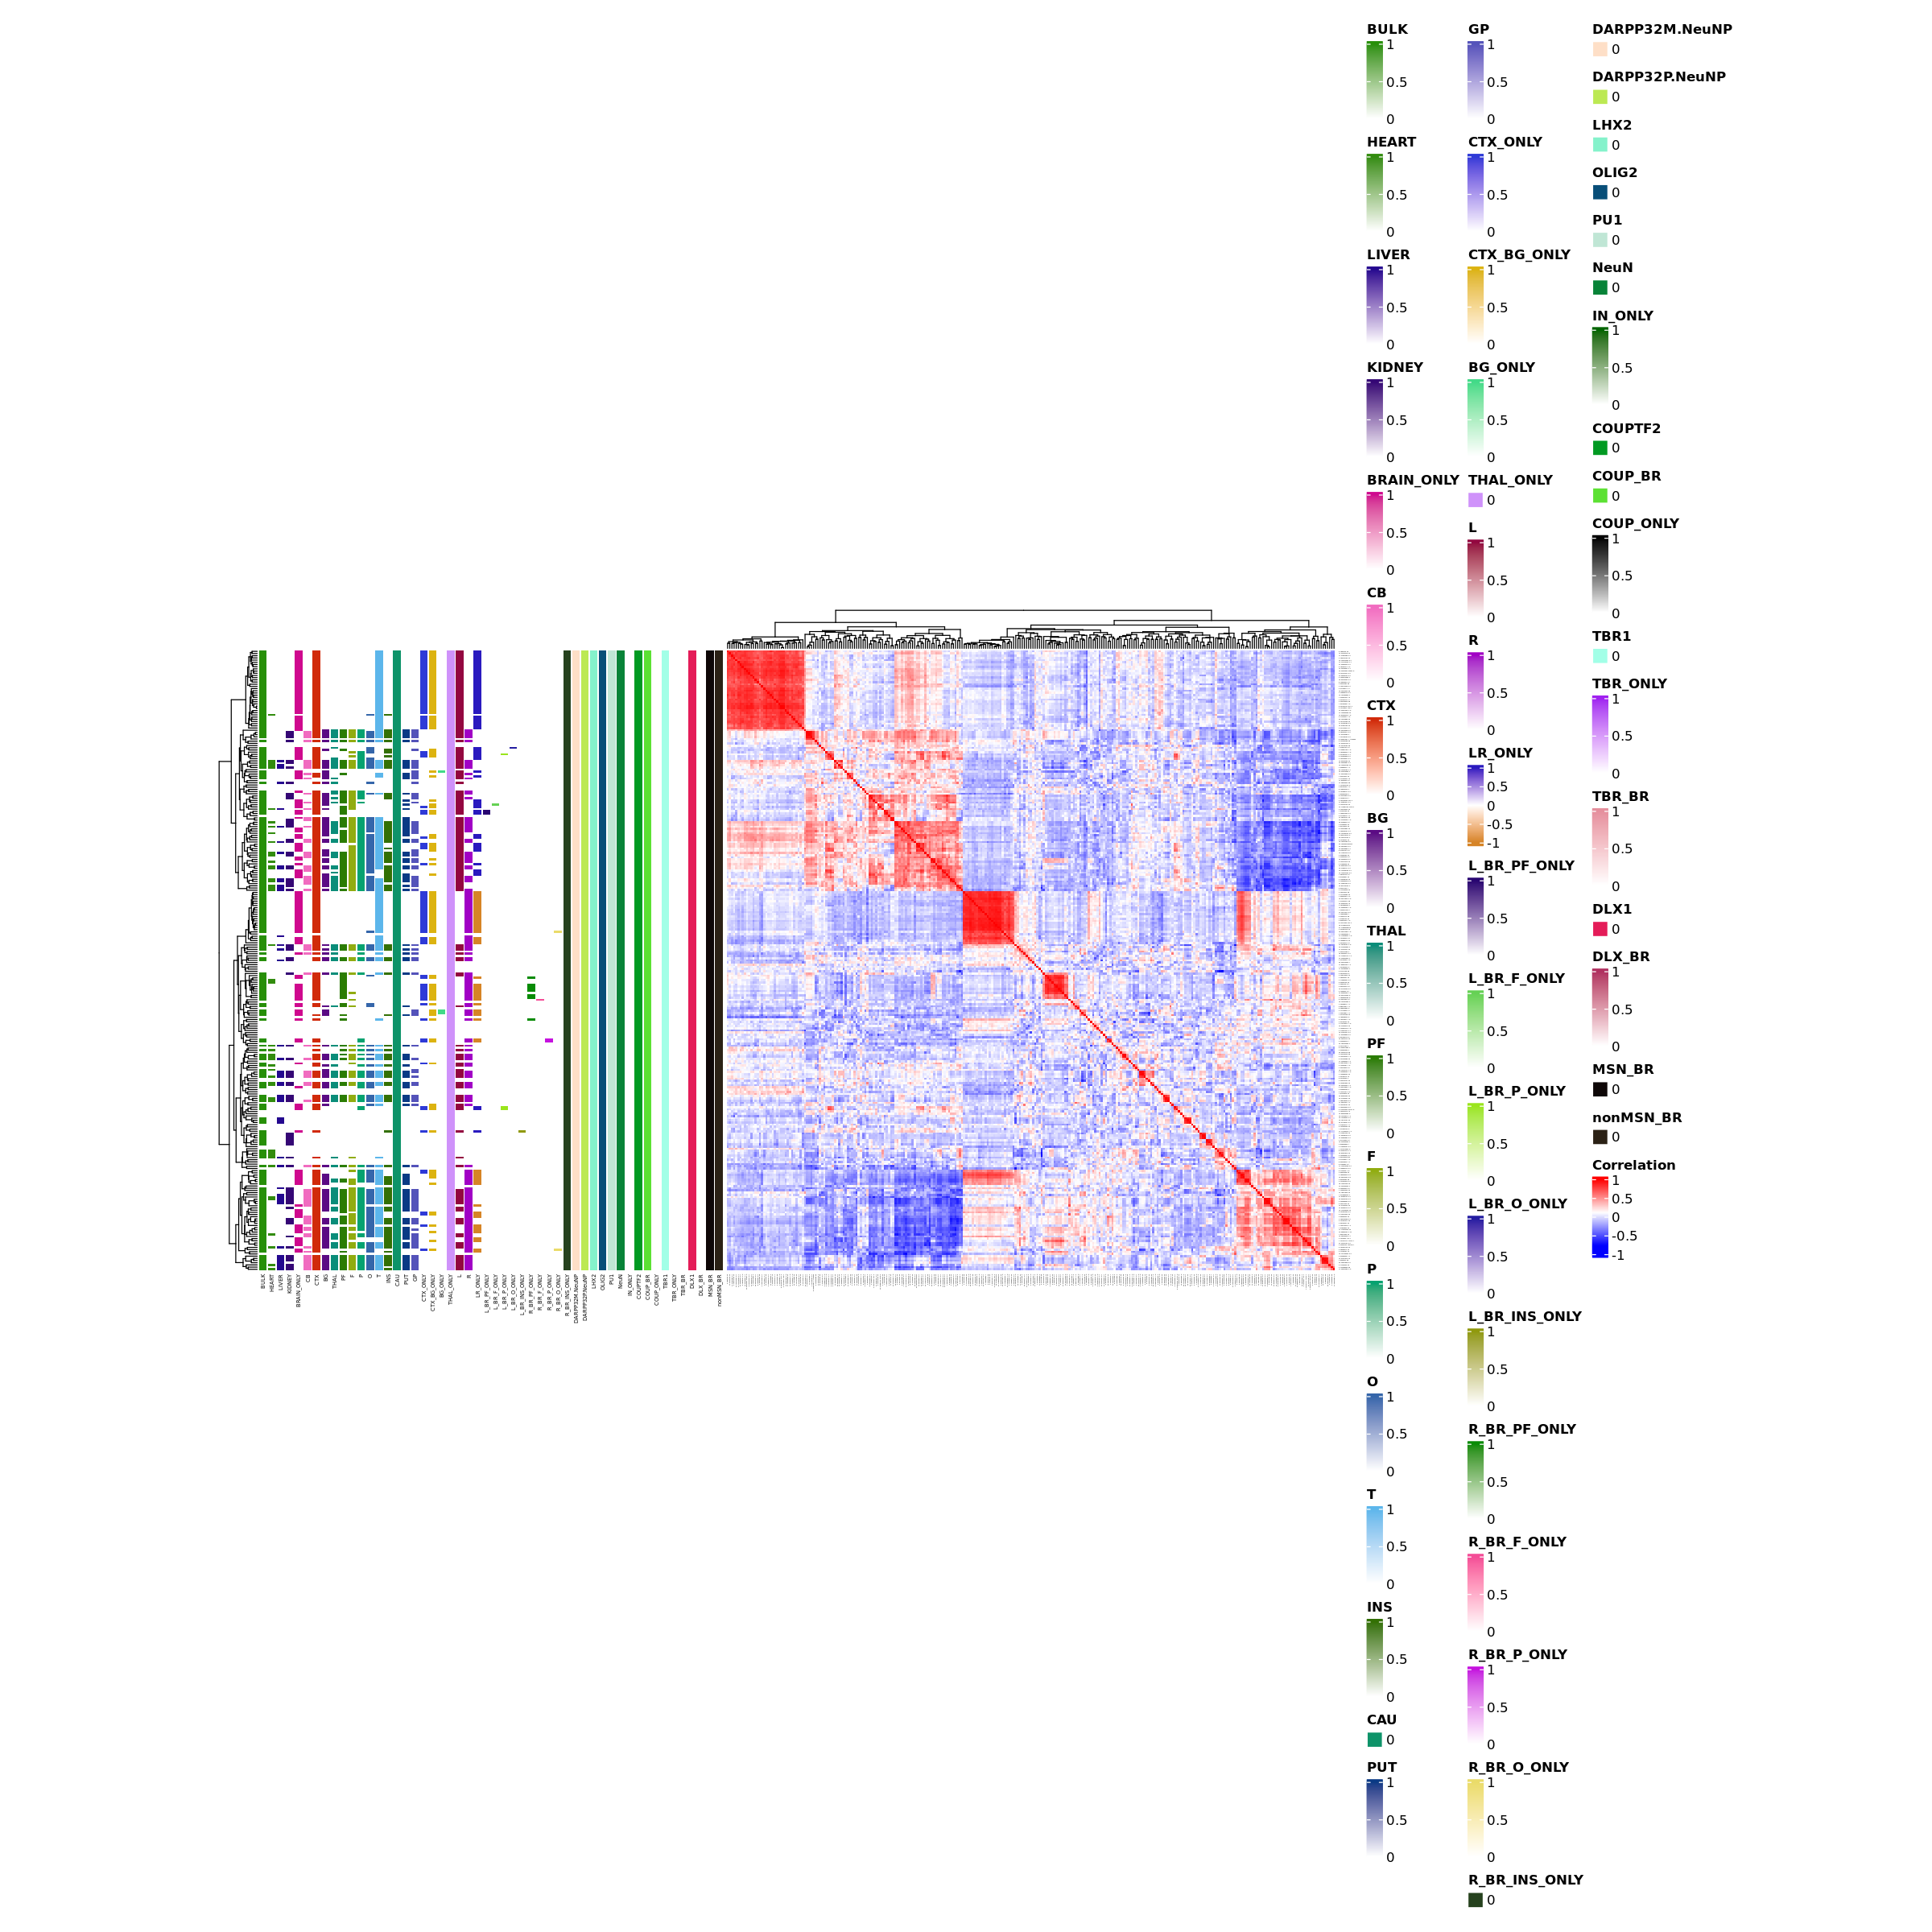

In [37]:
complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [38]:
pdf(file="7614_VarByVar_Bulk_main_283_Var.pdf",width=40,height=40)
complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap
dev.off()

png 
  2

# COUPTF2

In [2]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [3]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# brain_only_shared_mosaic_filtered<-shared_mosaic_filtered[shared_mosaic_filtered$CHROM.POS.REF.ALT %in% shared_variant_list[shared_variant_list$CTX_only=='1',]$variant_list,]

# output: shared/validated variant's MAF with sample and other annotation.

In [4]:
#length(unique(shared_variant_list$CHROM.POS.REF.ALT))
length(unique(shared_variant_list$variant_list))
#length(unique(shared_mosaic_filtered$CHROM.POS.REF.ALT))

[1] 146

In [5]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('COUPTF2'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 1752

In [6]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 12

In [7]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [8]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [9]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson",use="pairwise.complete.obs")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 146"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 146"


In [10]:
length(myCol$Ins_COUPTF2)

[1] 146

In [11]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")),
                      
                  IN_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")),
                                        
                  DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_BR = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")))
                  
left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        HEART = myCol$Heart,
                                        LIVER = myCol$Liver,
                                        KIDNEY = myCol$Kidney,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX_COUPTF2,
                                        BG = myCol$BG_COUPTF2,
                                        THAL = myCol$THAL_COUPTF2,
                                        HIP = myCol$HIP_COUPTF2,
                                        PF = myCol$PF_COUPTF2,
                                        F = myCol$F_COUPTF2,
                                        P = myCol$P_COUPTF2,
                                        O = myCol$O_COUPTF2,
                                        T = myCol$T_COUPTF2,
                                        INS = myCol$Ins_COUPTF2,
                                        CTX_ONLY = myCol$CTX_only_COUPTF2,
                                        CTX_BG_ONLY = myCol$CTX_BG_only_COUPTF2,
                                        BG_ONLY = myCol$BG_only_COUPTF2,
                                        THAL_ONLY = myCol$THAL_only_COUPTF2,
                                        L = myCol$L_COUPTF2,
                                        R = myCol$R_COUPTF2,
                                        LR_ONLY = myCol$Left_only_COUPTF2 - myCol$Right_only_COUPTF2,
                                            
                                        IN_ONLY = myCol$IN_only_sort,
                                        TBR_ONLY = myCol$TBR_only_sort,
                                        COUP_ONLY = myCol$COUP_only_sort,
                                        
                                        DLX_BR = myCol$DLX_BR_sort,
                                        TBR_BR = myCol$TBR_BR_sort,
                                        COUP_BR = myCol$COUP_BR_sort,
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


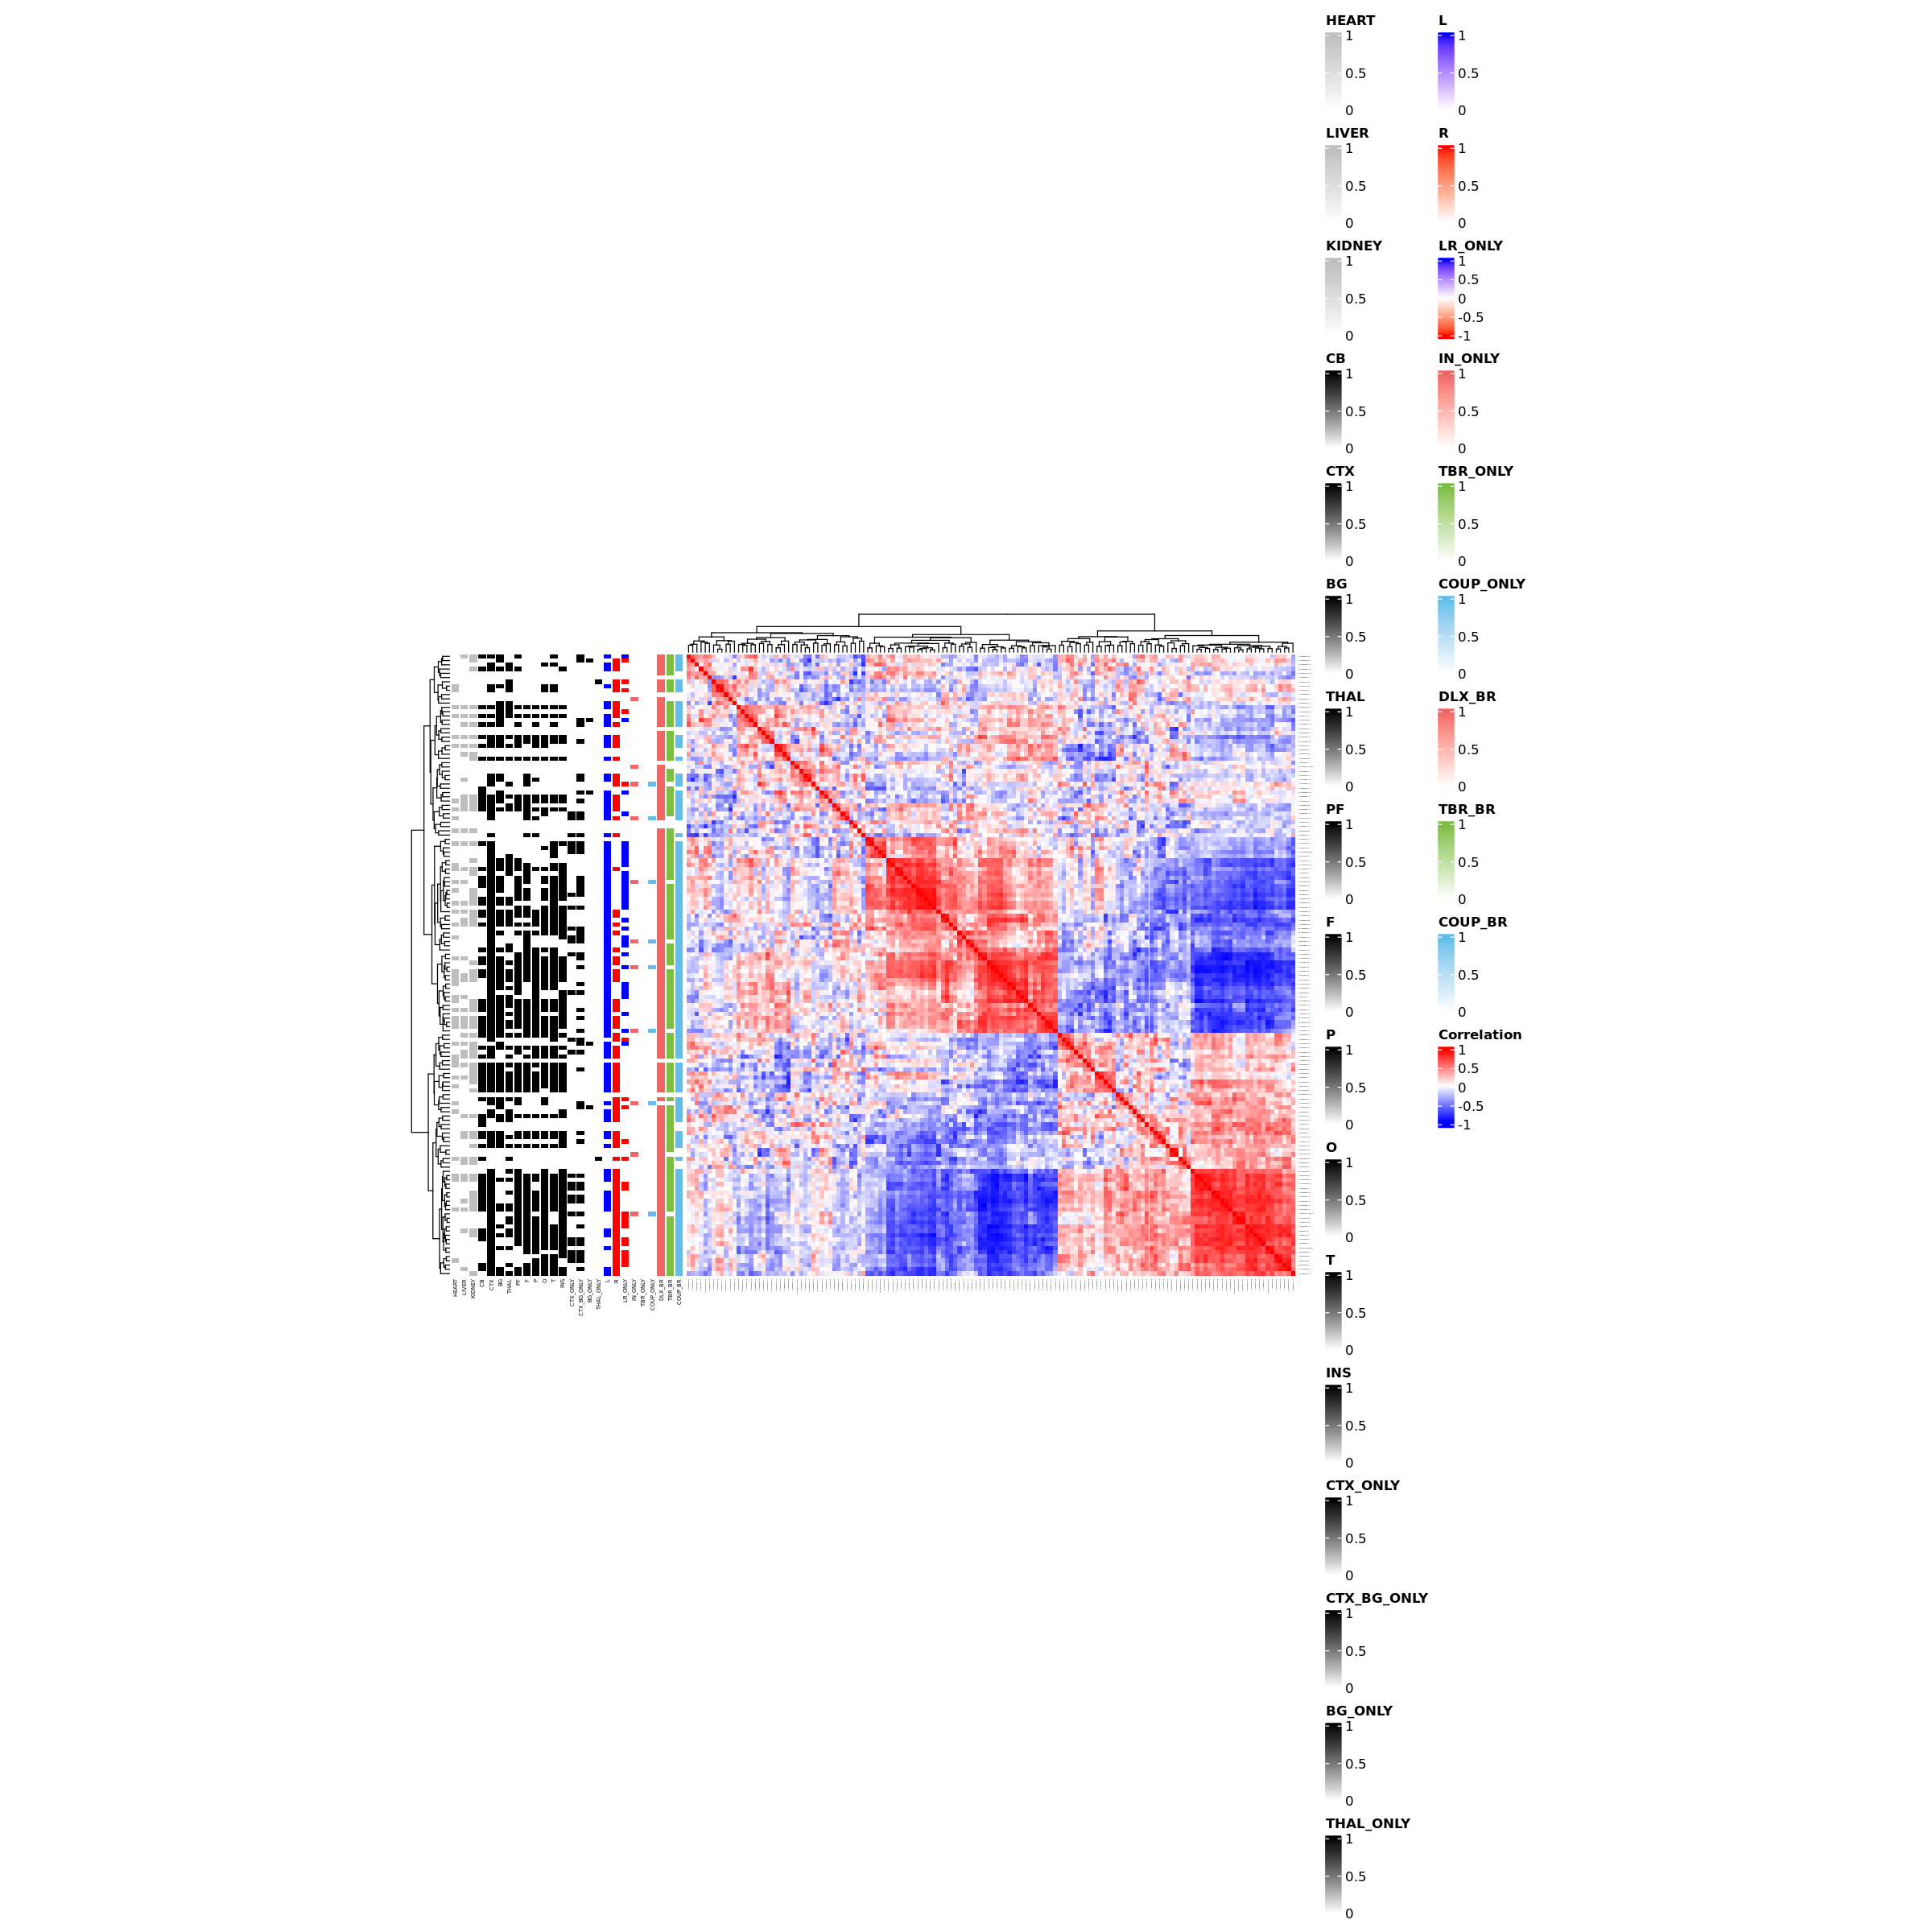

In [12]:
# sorted main COUPTFII

Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [13]:
pdf(file="/projects/ps-gleesonlab8/User/chchung/Interneuron/20230114_7614_Ampliseq_QC/VarXVar_plots/7614_VarByVar_COUPTF2_shared_Var.pdf",width=40,height=40)
complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap
dev.off()

png 
  2

# TBR1

In [34]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# brain_only_shared_mosaic_filtered<-shared_mosaic_filtered[shared_mosaic_filtered$CHROM.POS.REF.ALT %in% shared_variant_list[shared_variant_list$CTX_only=='1',]$variant_list,]

# output: shared/validated variant's MAF with sample and other annotation.

In [35]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('TBR1'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 1752

In [36]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 12

In [37]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [38]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [39]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 146"
[1] "removed rows due to zero values in all column : 1"
[1] "remaining rows : 145"


In [40]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")),
                      
                  IN_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")),
                                        
                  DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_BR = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        HEART = myCol$Heart,
                                        LIVER = myCol$Liver,
                                        KIDNEY = myCol$Kidney,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX_TBR1,
                                        BG = myCol$BG_TBR1,
                                        THAL = myCol$THAL_TBR1,
                                        HIP = myCol$HIP_TBR1,
                                        PF = myCol$PF_TBR1,
                                        F = myCol$F_TBR1,
                                        P = myCol$P_TBR1,
                                        O = myCol$O_TBR1,
                                        T = myCol$T_TBR1,
                                        INS = myCol$Ins_TBR1,
                                        CTX_ONLY = myCol$CTX_only_TBR1,
                                        CTX_BG_ONLY = myCol$CTX_BG_only_TBR1,
                                        BG_ONLY = myCol$BG_only_TBR1,
                                        THAL_ONLY = myCol$THAL_only_TBR1,
                                        L = myCol$L_TBR1,
                                        R = myCol$R_TBR1,
                                        LR_ONLY = myCol$Left_only_TBR1 - myCol$Right_only_TBR1,
                                            
                                        IN_ONLY = myCol$IN_only_sort,
                                        TBR_ONLY = myCol$TBR_only_sort,
                                        COUP_ONLY = myCol$COUP_only_sort,
                                        
                                        DLX_BR = myCol$DLX_BR_sort,
                                        TBR_BR = myCol$TBR_BR_sort,
                                        COUP_BR = myCol$COUP_BR_sort,
                                        nonMSN_BR = myCol$nonMSN_BR,
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


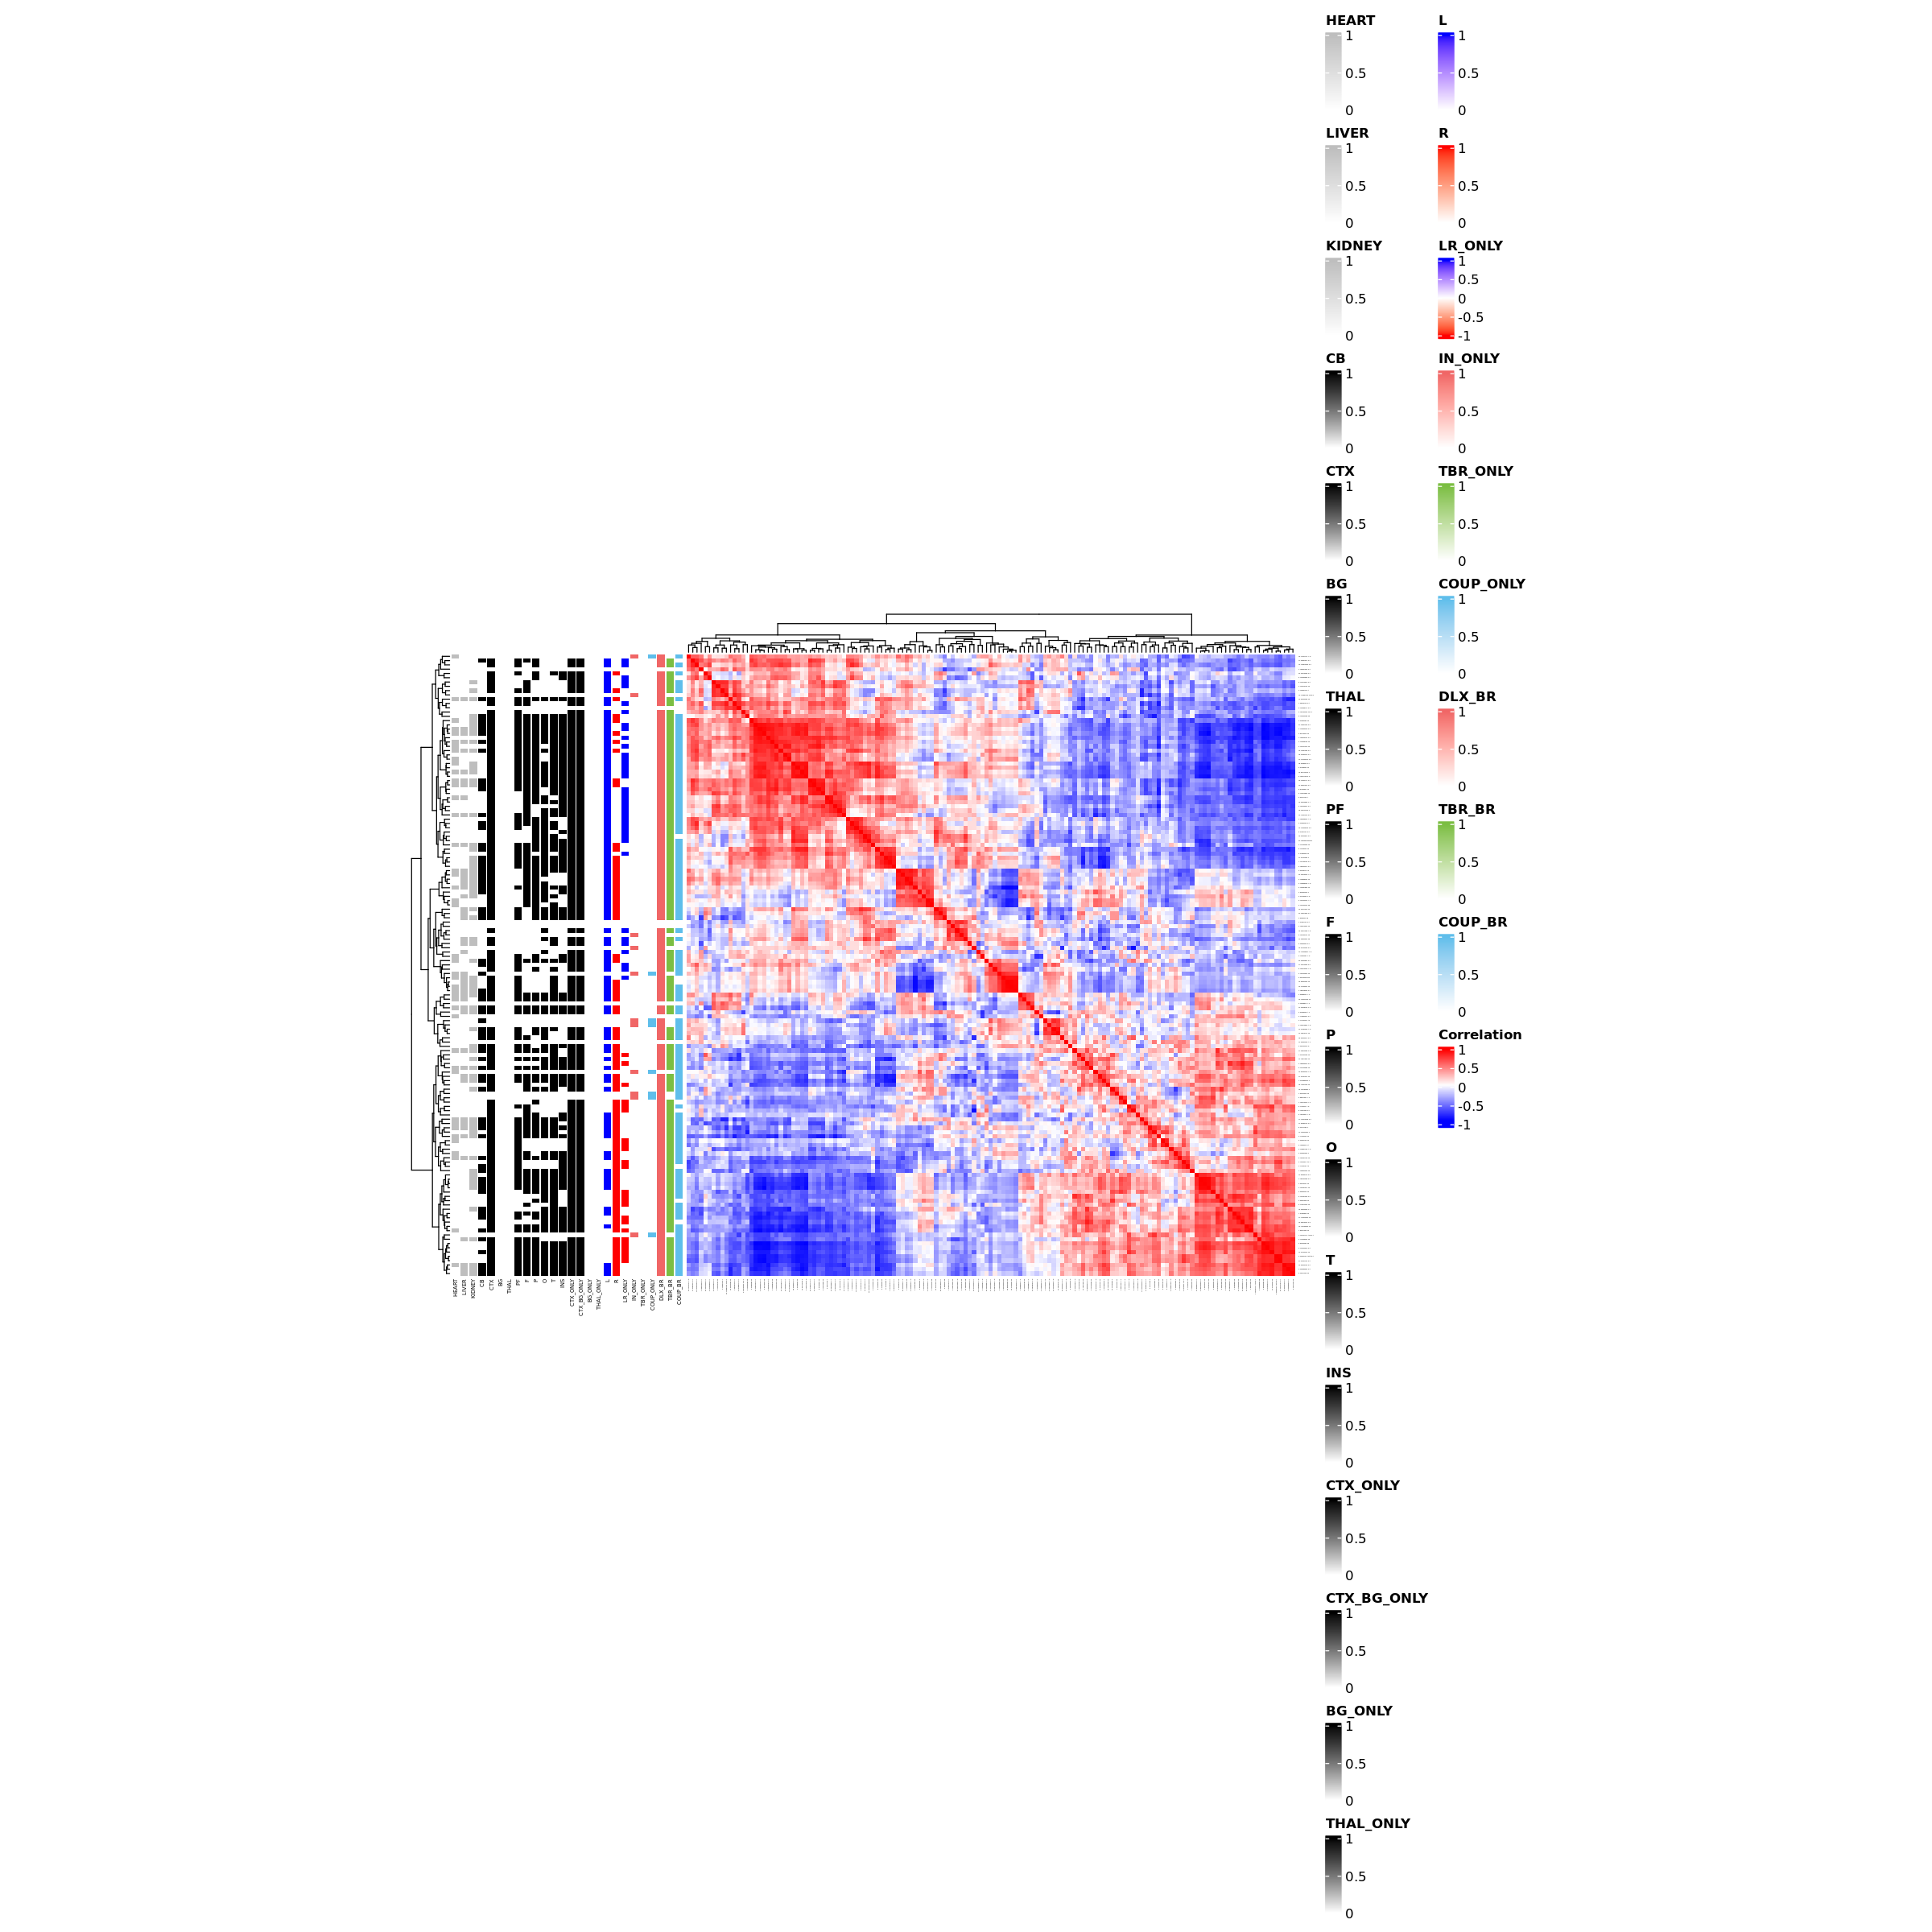

In [41]:
# sorted main TBR1

Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [42]:
pdf(file="/projects/ps-gleesonlab8/User/chchung/Interneuron/20230114_7614_Ampliseq_QC/VarXVar_plots/7614_VarByVar_TBR1_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# DLX1

In [2]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [3]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# brain_only_shared_mosaic_filtered<-shared_mosaic_filtered[shared_mosaic_filtered$CHROM.POS.REF.ALT %in% shared_variant_list[shared_variant_list$CTX_only=='1',]$variant_list,]

# output: shared/validated variant's MAF with sample and other annotation.

In [4]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('DLX1'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 1606

In [5]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 11

In [6]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [7]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [8]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 146"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 146"


In [9]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CTX_BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")),
                      
                  IN_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_ONLY = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")),
                                        
                  DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "#F06666")),
                  TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#7BBE42")),
                  COUP_BR = colorRamp2(c(0, 1), c("#ffffff", "#5FBEEB")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        HEART = myCol$Heart,
                                        LIVER = myCol$Liver,
                                        KIDNEY = myCol$Kidney,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX_DLX1,
                                        BG = myCol$BG_DLX1,
                                        THAL = myCol$THAL_DLX1,
                                        HIP = myCol$HIP_DLX1,
                                        PF = myCol$PF_DLX1,
                                        F = myCol$F_DLX1,
                                        P = myCol$P_DLX1,
                                        O = myCol$O_DLX1,
                                        T = myCol$T_DLX1,
                                        INS = myCol$Ins_DLX1,
                                        CTX_ONLY = myCol$CTX_only_DLX1,
                                        CTX_BG_ONLY = myCol$CTX_BG_only_DLX1,
                                        BG_ONLY = myCol$BG_only_DLX1,
                                        THAL_ONLY = myCol$THAL_only_DLX1,
                                        L = myCol$L_DLX1,
                                        R = myCol$R_DLX1,
                                        LR_ONLY = myCol$Left_only_DLX1 - myCol$Right_only_DLX1,
                                            
                                        IN_ONLY = myCol$IN_only_sort,
                                        TBR_ONLY = myCol$TBR_only_sort,
                                        COUP_ONLY = myCol$COUP_only_sort,
                                        
                                        DLX_BR = myCol$DLX_BR_sort,
                                        TBR_BR = myCol$TBR_BR_sort,
                                        COUP_BR = myCol$COUP_BR_sort,
                                        nonMSN_BR = myCol$nonMSN_BR,
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


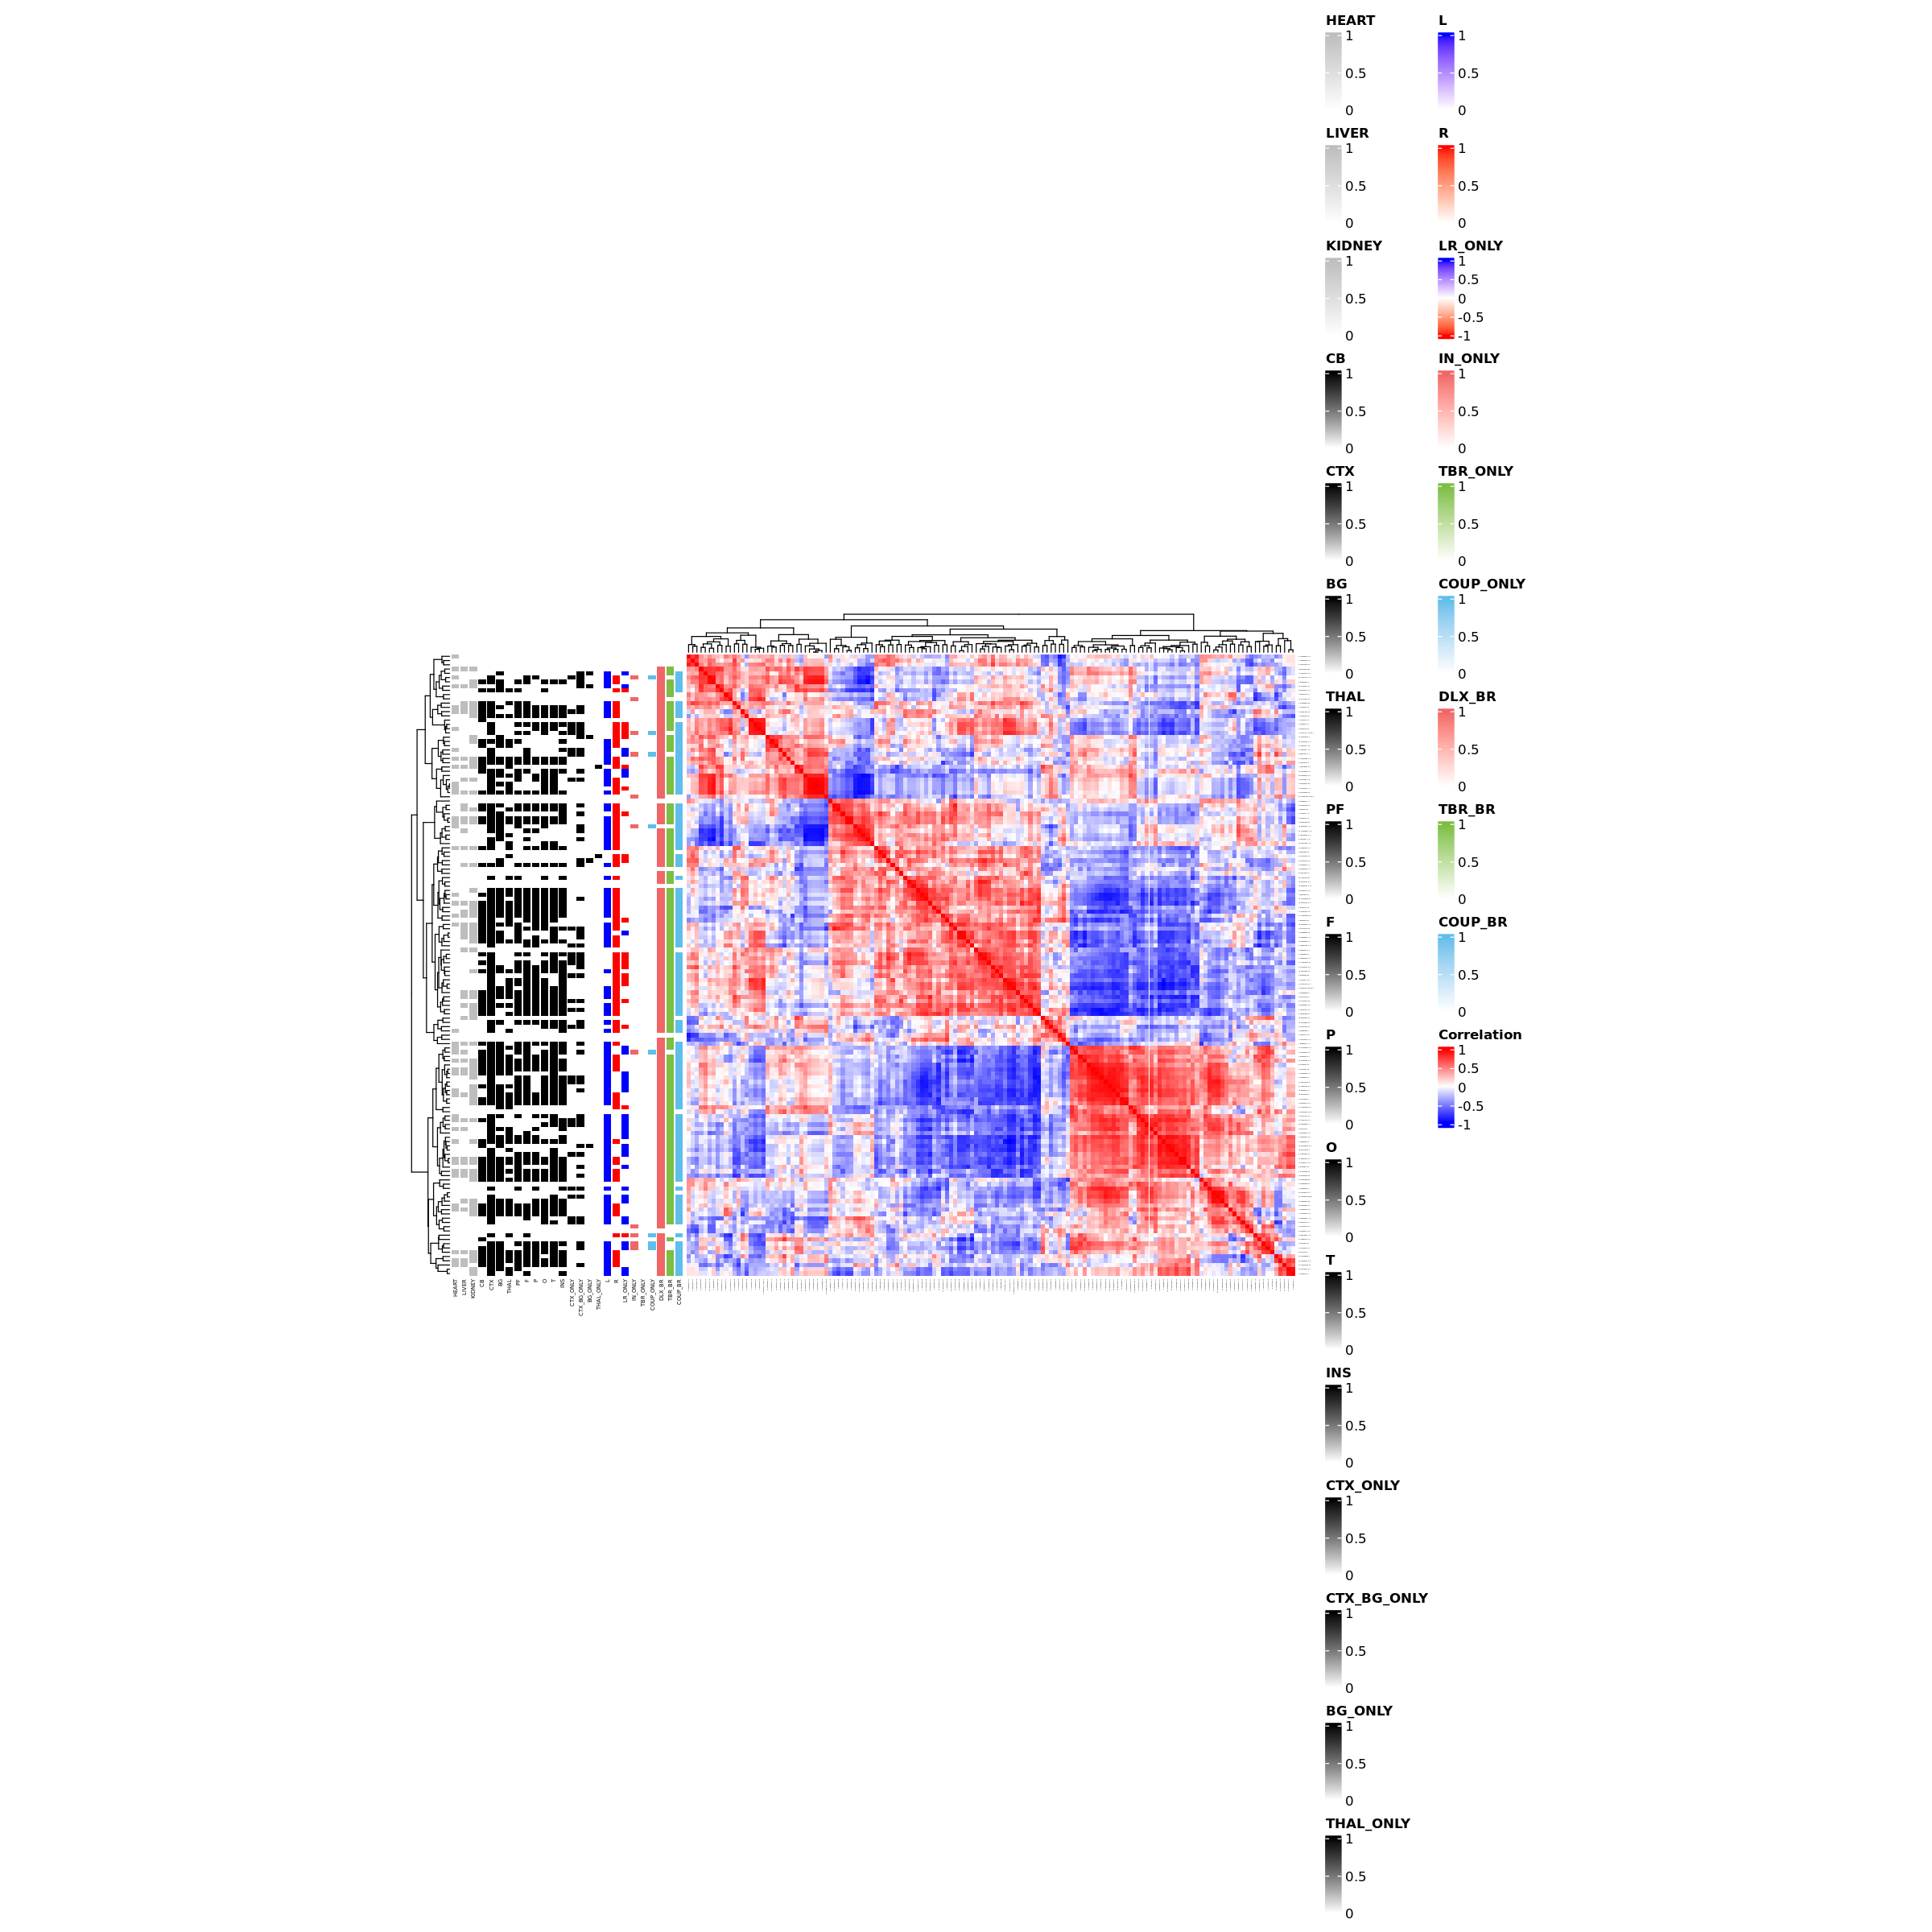

In [10]:
# sorted main DLX1
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [11]:
pdf(file="/projects/ps-gleesonlab8/User/chchung/Interneuron/20230114_7614_Ampliseq_QC/VarXVar_plots/7614_VarByVar_DLX1_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# sorted main all

In [122]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [134]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>0,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [142]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('DLX1','TBR1','COUPTF2'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 7820

In [143]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 34

In [144]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [145]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [146]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 230"
[1] "removed rows due to zero values in all column : 2"
[1] "remaining rows : 228"


In [147]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
color_list = list(LR_ONLY = LR_colors,
                COUP_ONLY = colorRamp2(c(0, 1), c("#ffffff", "black")),
                IN_ONLY = colorRamp2(c(0, 1), c("#ffffff", "darkgreen")),
                TBR_ONLY = colorRamp2(c(0, 1), c("#ffffff", "purple")), 
                TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#e58f9d")),
                DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "maroon")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        BULK = myCol$Bulk,
                                        HEART = myCol$Heart,
                                        LIVER = myCol$Liver,
                                        KIDNEY = myCol$Kidney,
                                        BRAIN_ONLY = myCol$Brain_only,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX_sort,
                                        BG = myCol$BG_sort,
                                        THAL = myCol$THAL_sort,
                                        HIP = myCol$HIP_sort,
                                        PF = myCol$PF_sort,
                                        F = myCol$F_sort,
                                        P = myCol$P_sort,
                                        O = myCol$O_sort,
                                        T = myCol$T_sort,
                                        INS = myCol$Ins_sort,
                                        CTX_ONLY = myCol$CTX_only_sort,
                                        CTX_BG_ONLY = myCol$CTX_BG_only_sort,
                                        BG_ONLY = myCol$BG_only_sort,
                                        THAL_ONLY = myCol$THAL_only_sort,
                                        L = myCol$L_sort,
                                        R = myCol$R_sort,
                                        LR_ONLY = myCol$Left_only_sort - myCol$Right_only_sort,
                                            
                                        IN_ONLY = myCol$IN_only_sort,
                                        TBR_ONLY = myCol$TBR_only_sort,
                                        COUP_ONLY = myCol$COUP_only_sort,
                                        
                                        DLX_BR = myCol$DLX_BR_sort,
                                        TBR_BR = myCol$TBR_BR_sort,
                                        COUP_BR = myCol$COUP_BR_sort,
                                        nonMSN_BR = myCol$nonMSN_BR,
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


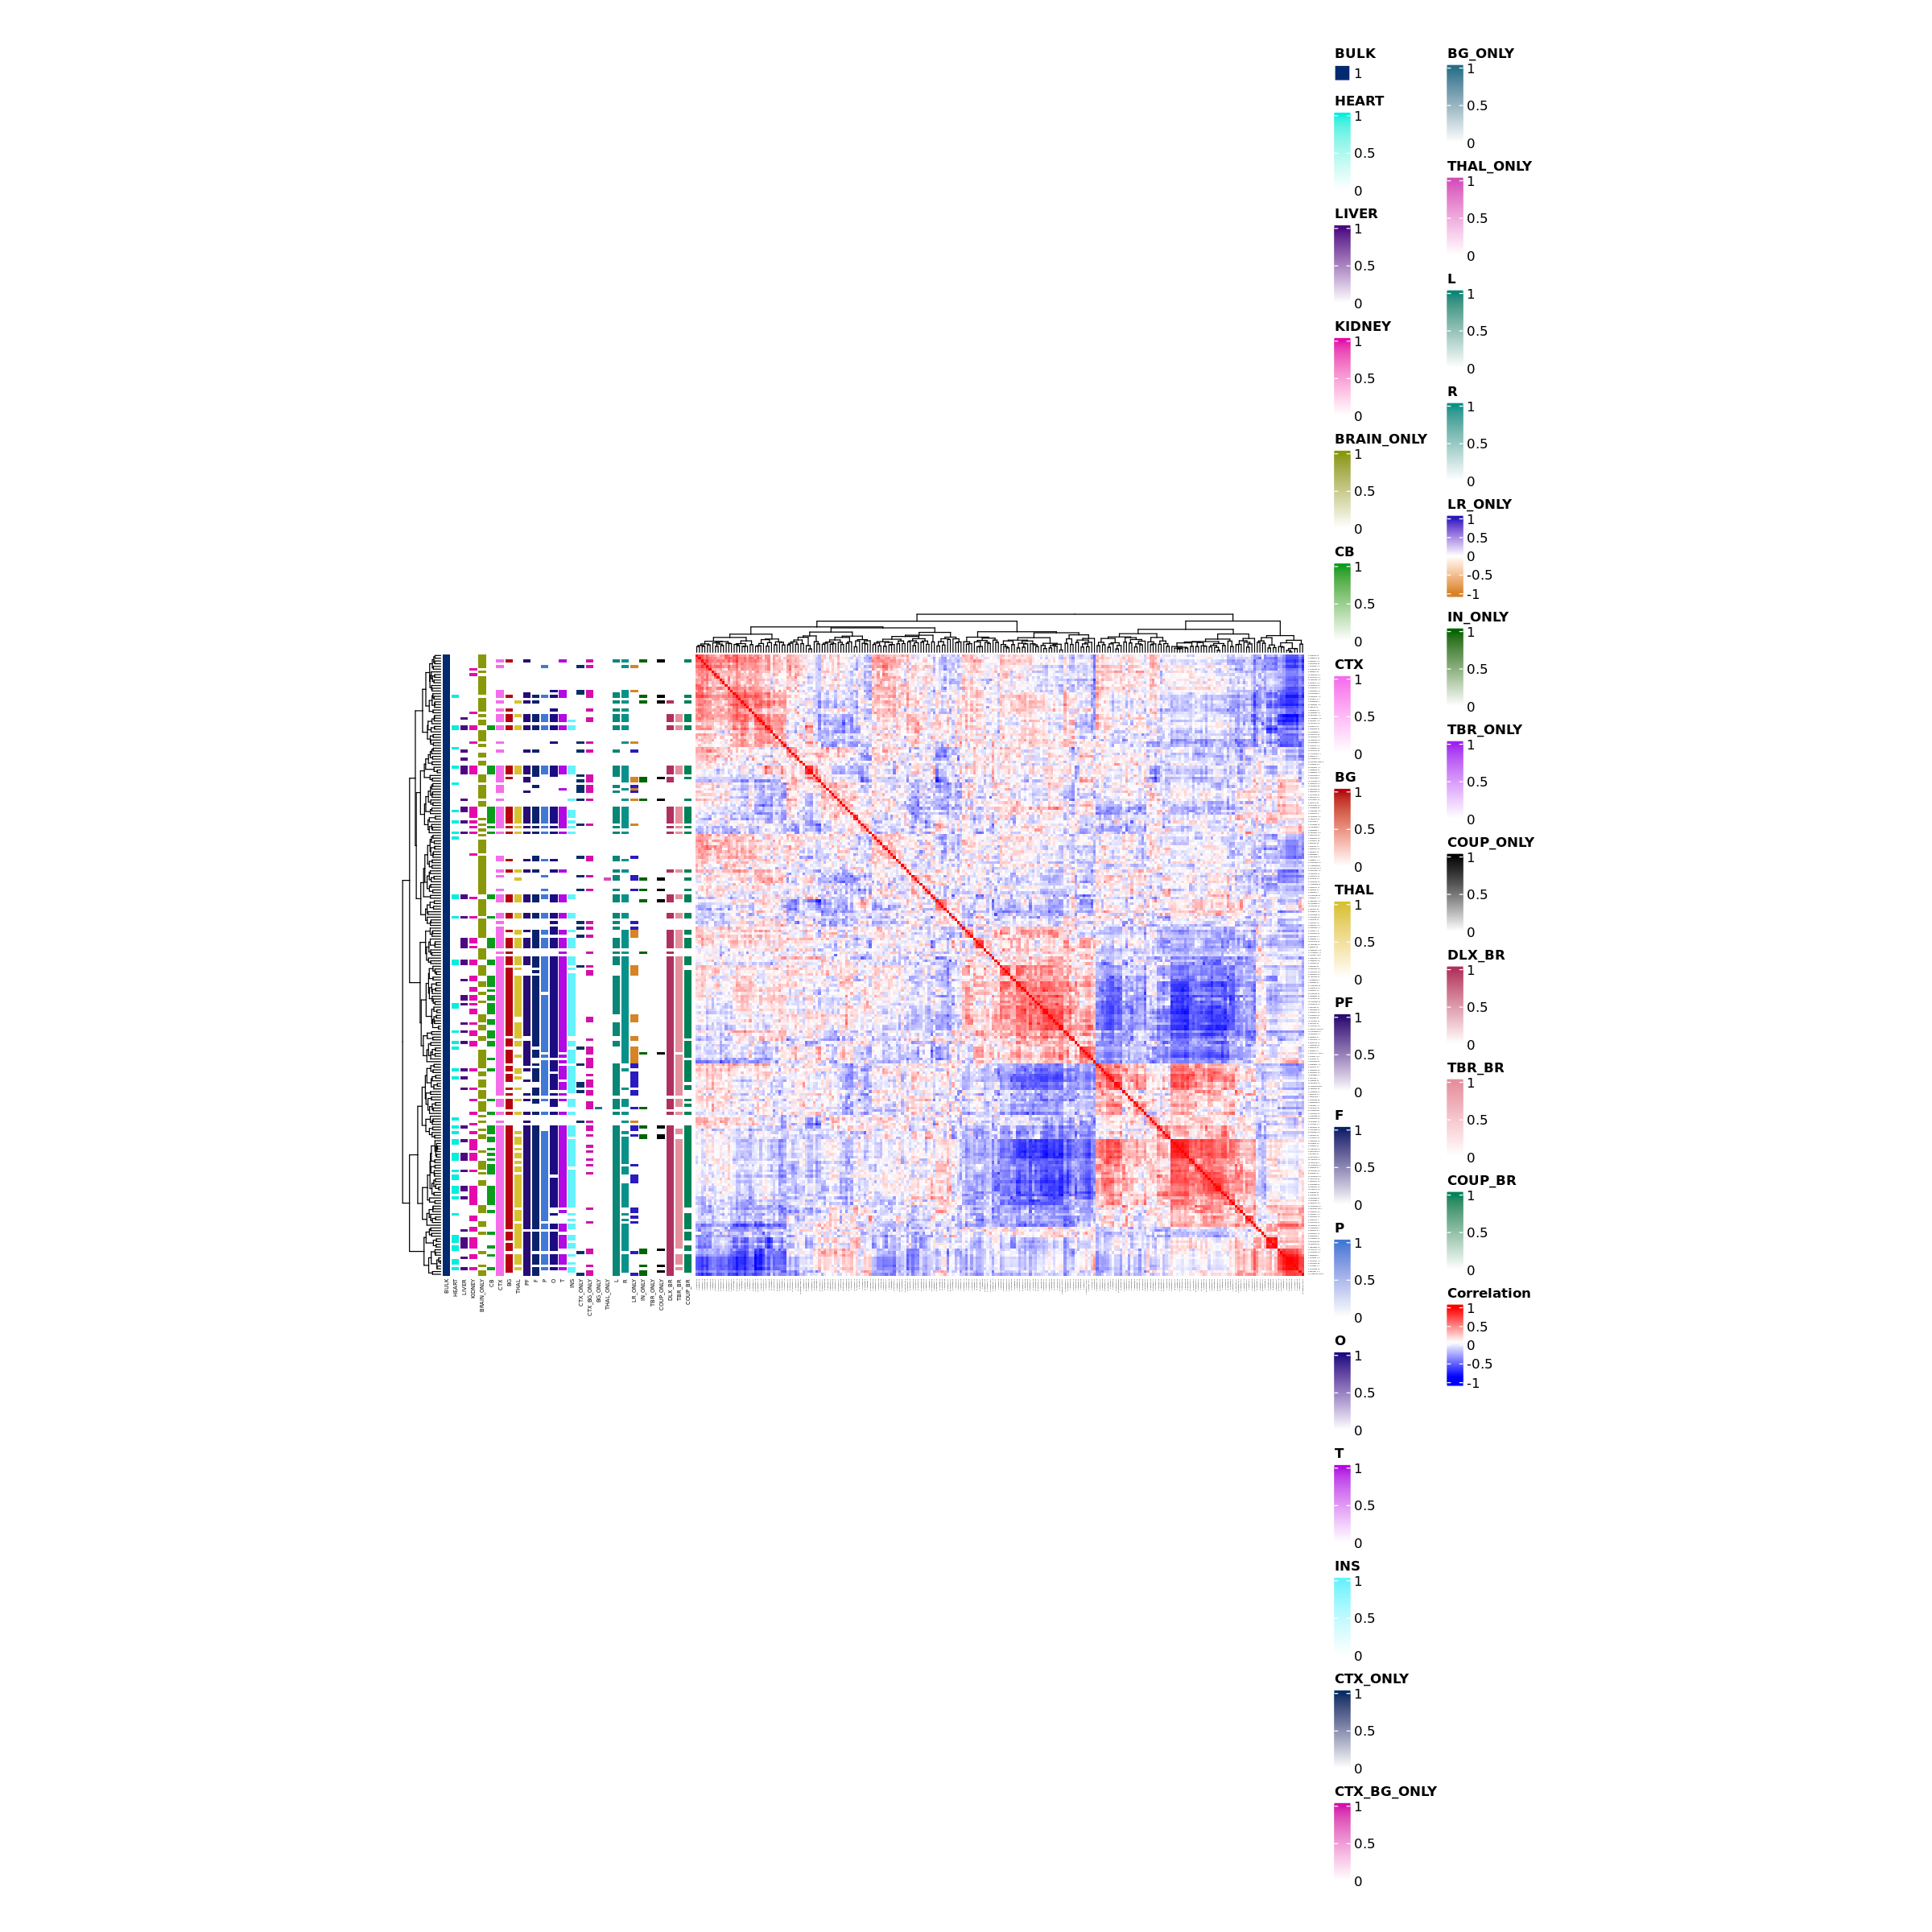

In [148]:
# sorted main DLX1
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [ ]:
pdf(file="7614_VarByVar_sorted_main_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()